In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from data.prepare_data import *
from data.prepare_word2vec_ed import *

# Pocet odpovedi - bar plot

In [3]:
os.chdir('/home/daniel/school/BP/pythesis')
logs = pd.read_csv('data/nova_doplnovacka_log.csv', sep=';')
questions = pd.read_csv('data/nova_doplnovacka_questions.csv', sep=';')
system_ps_problem = pd.read_csv('data/system_ps_problem.csv', sep=';')
system_ps = pd.read_csv('data/system_ps.csv', sep=';')
system_kc = pd.read_csv('data/system_kc.csv', sep=';')
# dropping duplicates of answers for each user
basic_data = merge_logs_with_questions(logs, questions).drop_duplicates(['user', 'question_id'], keep='first')
# left join from no duplicates data with practice sets and its parent_kc -> dropping rows where the parent_kc is multiple times fors one answer
ps_data = merge_data_with_practice_sets(basic_data, system_ps_problem, system_ps).drop_duplicates(['id', 'parent_kc'], keep='first')

In [42]:
count_kcs = ps_data['parent_kc'].value_counts().head(30)
count_kcs = count_kcs.drop(1)

In [43]:
practice_sets_table = system_kc[['id','name']].set_index('id')
practice_sets_answers_count = count_kcs.to_frame().join(practice_sets_table)
practice_sets_answers_count.columns = ['count', 'name']
practice_sets_answers_count.index.names = ['kc_id']

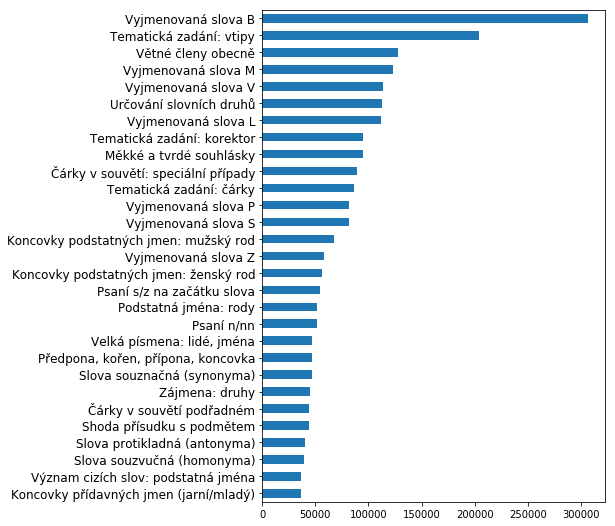

In [56]:
df = practice_sets_answers_count
labels= df['name'].tolist()
df.plot(kind='barh', legend=False)
plt.gca().invert_yaxis()
plt.gca().set_yticklabels(labels, fontsize=12)
plt.tight_layout()
plt.gcf().set_size_inches(15, 8)
plt.ylabel('')
# plt.title('Counts of answers for knowledge components (top30)', color='black')
# plt.savefig('visualizations/matplotlib/counts_of_answers_for_knowledge_components.svg')
plt.show()

# Correlation all data from fill-in exercises

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

from data.prepare_data import *
from data.prepare_word2vec_ed import *
from similarities.text_similarities import levenshtein_similarity, minimum_edit_distance, levenshtein_similarity_with_threshold

def get_ps_data():
    logs = pd.read_csv('data/nova_doplnovacka_log.csv', sep=';')
    questions = pd.read_csv('data/nova_doplnovacka_questions.csv', sep=';')
    system_ps_problem = pd.read_csv('data/system_ps_problem.csv', sep=';')
    system_ps = pd.read_csv('data/system_ps.csv', sep=';')
    system_kc = pd.read_csv('data/system_kc.csv', sep=';')
    basic_data = merge_logs_with_questions(logs, questions)
    ps_data = merge_data_with_practice_sets(basic_data, system_ps_problem, system_ps)
    return ps_data

In [5]:
ps_data = get_ps_data().drop_duplicates(['user','question_id'])
model = Word2Vec.load('utils/word2vec.model')

In [6]:
final_data = ps_data[ps_data['question'].apply(lambda x: x.count('_')) == 1].copy()

In [9]:
len(final_data.question_id.unique())

5647

In [10]:
X, data = get_word2vec_items(model, final_data)
# some questions with same text are labeled in more question_ids
data.sort_values(['question_id'], inplace=True)
data.drop_duplicates(['question'], inplace=True)

In [11]:
print('%d out of %d words are not in our word2vec model' % (len(final_data.question_id.unique()) - len(data.question_id.unique()), len(final_data.question_id.unique())))

874 out of 5647 words are not in our word2vec model


In [12]:
# to get only the not duplicated data from our word2vec model
filtered = final_data.loc[final_data['question_id'].isin(data['question_id'])]
correctness_matrix = reshape_to_correctness_matrix(filtered)

In [13]:
len(filtered.question_id.unique())

4773

In [46]:
# pearson = correctness_matrix_to_similarity_matrix('pearson', correctness_matrix)
pearson = pd.read_csv('data/processed/all_fillin_exercises/simmatrix-pearson-all_fillin_exercises_data.csv', index_col=0)

In [50]:
# pearson2 = pearson.corr()
pearson2 = pd.read_csv('data/processed/all_fillin_exercises/simmatrix-doublepearson-all_fillin_exercises_data.csv', index_col=0)

In [ ]:
# editdistance = create_edit_similarity_matrix(data['question_id'], data['solution'], levenshtein_similarity)

In [31]:
# word2vec = create_word2vec_similarity_matrix(model, data['question_id'], data['solution'])

In [54]:
similarities = pd.DataFrame()
# similarities['ed'] = editdistance.values.flatten().astype(float)
similarities['pearson'] = pearson.values.flatten().astype(float)
similarities['doublepearson'] = pearson2.values.flatten().astype(float)
# similarities['word2vec'] = word2vec.values.flatten().astype(float)

In [55]:
similarities.corr()

,pearson,doublepearson
pearson,1.000000,0.721981
doublepearson,0.721981,1.000000


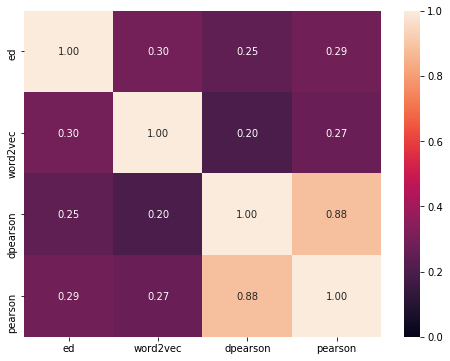

In [51]:
# editdistance, word2vec, doublepearson, pearson = get_simmatrices(data)
corr_matrix = get_correlation_matrix(editdistance, word2vec, doublepearson, pearson)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", vmin=0)
plt.gcf().set_size_inches(8, 6)
plt.savefig('visualizations/seaborn/heatmap-correlations-measures-%s.png' % dataset['name'])
plt.show()